## Surface classification and automatic detection of supraglacial lakes

During the Arctic summer, surface melting on the Greenland Ice Sheet can produce meltwater near the ice sheet's margins. 
The seasonal meltwater pools in supraglacial lakes in topographic lows on the ice surface and forms a dendritic pattern of meandering streams and rivers that often connects the lakes hydrologically (e.g., [Studinger et al., 2022](https://doi.org/10.5194/tc-16-3649-2022)).

This tutorial demonstrates how natural-color (RGB) imagery can be utilized for ice/water surface classification and lake detection using classic image segmentation methods such as Otsu multi-thresholding and Connected Component Analysis (CCA) on both natural color imagery and the **N**ormalized **D**ifference **W**ater **I**ndex modified for **ice** (NDWI<sub>ice</sub>) derived from RGB images.   

To detect water on the ice sheet, the **N**ormalized **D**ifference **W**ater **I**ndex modified for **ice** (NDWI<sub>ice</sub>) that increases the spectral contrast between liquid water and snow and ice surfaces can be used (e.g., [Yang and Smith (2013)](https://doi.org/10.1109/LGRS.2012.2224316)). [Studinger et al., 2022](https://doi.org/10.5194/tc-16-3649-2022)) used NDWI<sub>ice</sub> for high-resolution surface classification of individual laser footprints from NASA's Airborne Topographic Mapper natural-color imagery. 
The NDWI<sub>ice</sub> of natural-color, three-channel (red, green, blue) images is defined as:


$$
\begin{align}
\textsf{NDWI}_\textsf{ice} = \frac{blue - red} {blue + red} \tag{1}
\end{align}
$$

## Step 1: Calculate NDWI<sub>ice</sub> from natural-color (RGB) imagery
First, load the required Python™ modules and build the image file name:

In [1]:
# load required Python™ modules and build file name for RGB image
import os
import cv2 as cv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patheffects as fx
from   PIL import Image
from   PIL import ImageEnhance
from   matplotlib.colors import ListedColormap

# set input directory with image file
f_dir_imagery = r".." + os.sep + "data" + os.sep + "imagery"
# set input file name for Jupyter notebook
f_name_rgb = f_dir_imagery + os.sep + "IOCAM0_2019_GR_NASA_20190506-131614.4217.jpg"
x_off = 100
y_off = 100

Import natural-color, three-channel (red, green, blue) image frame using the Pillow fork of the [Python Imaging Library](https://pillow.readthedocs.io/en/stable/). The lakes appear as sapphire-blue features to the eye and in natural color imagery. The image is appoximately 480 m wide and 310 m high. 

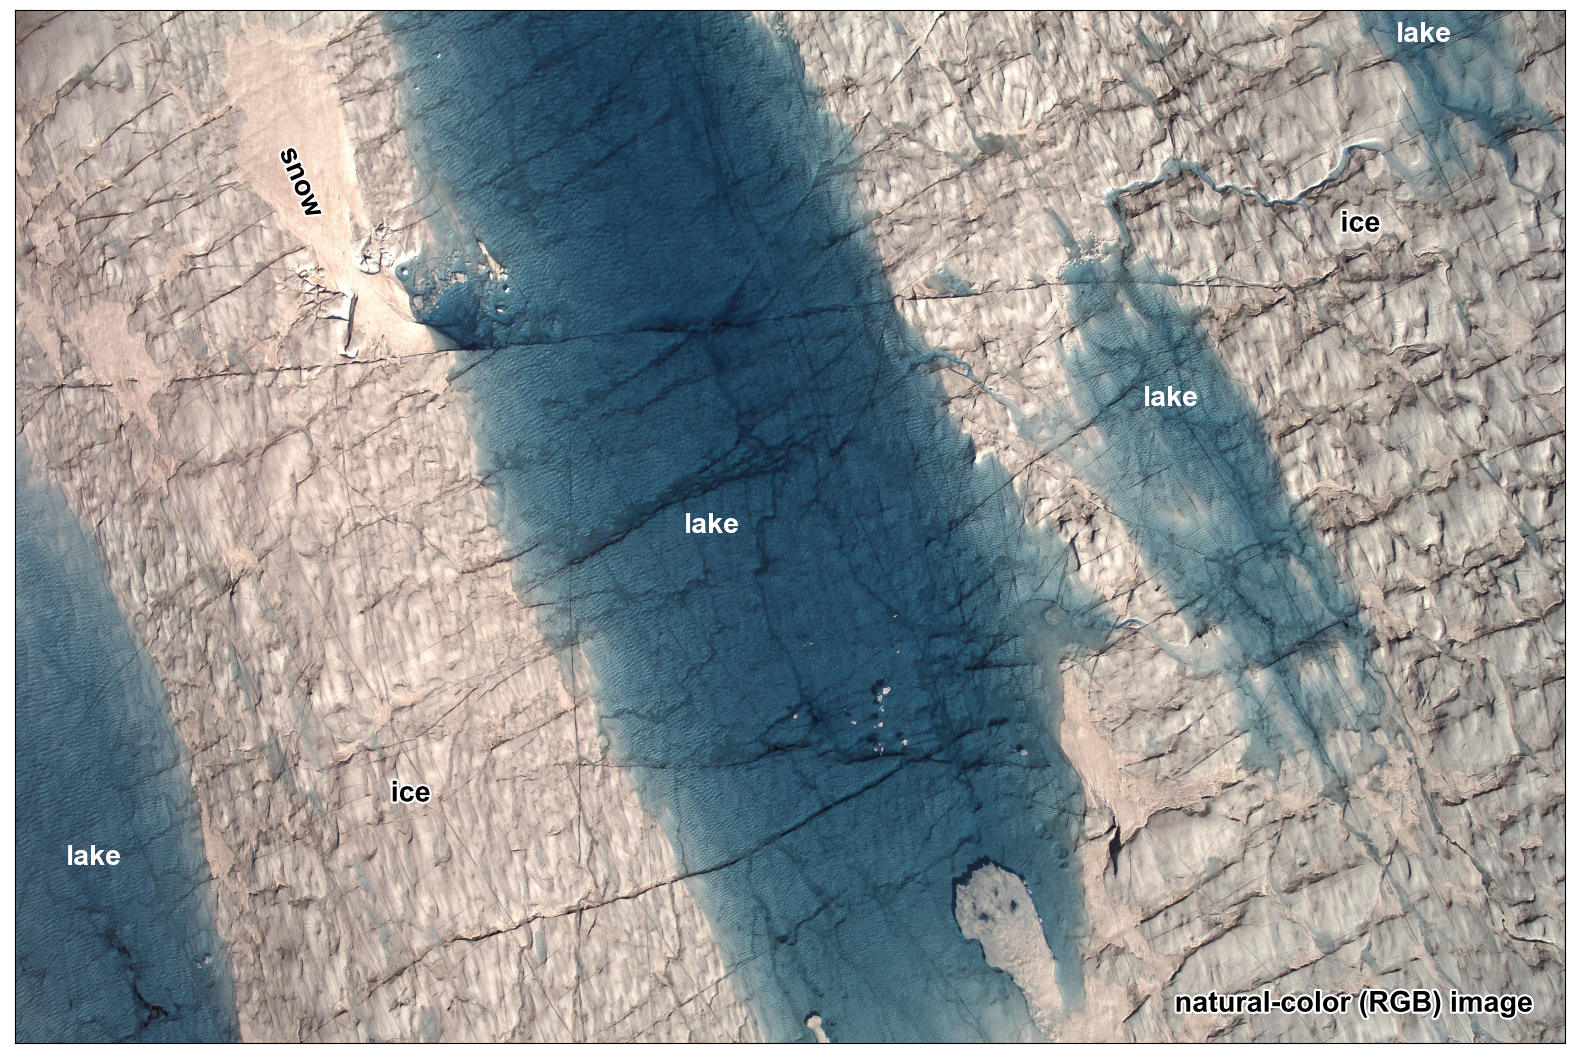

In [2]:
# import natural-color image as type Image, which is needed for OpenCV ImageEnhance
rgb_image = Image.open(f_name_rgb)
img_size = rgb_image.size # needed for positioning labels in plots below

# enhance brightness for display
enhancer  = ImageEnhance.Brightness(rgb_image)
rgb_adj   = enhancer.enhance(1.2) # brightens the image
# enhance contrast for display
enhancer  = ImageEnhance.Contrast(rgb_adj)
rgb_adj   = enhancer.enhance(1.1) # slightly increases contrast
# enhance sharpness for display
enhancer  = ImageEnhance.Sharpness(rgb_adj)
rgb_adj   = enhancer.enhance(8.5) # slightly increaes sharpness
# save enhanced image for image analysis 
f_name_adj = f_name_rgb.replace(".jpg", "_adj.jpg")
rgb_adj.save(f_name_adj) 

# import adjusted image as type unit8 array needed for image analysis
del rgb_image
image_adj = cv.imread(f_name_adj) # returns and array of uint8
assert image_adj is not None, "file could not be read, check with os.path.exists()"
rgb_image = cv.cvtColor(image_adj, cv.COLOR_BGR2RGB)

# plot RGB image
plt.rcParams['figure.figsize'] = [20, 15]
mpl.rcParams['font.size'] = 12

fig, (ax1)  = plt.subplots(1, 1, subplot_kw = {'xticks': [], 'yticks': []}) 
handle1_ax1 = ax1.imshow(rgb_image)
handle2_txt = ax1.text(1250,2500, "ice", fontsize = 'xx-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
handle3_txt = ax1.text(4250,700,  "ice", fontsize = 'xx-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
handle4_txt = ax1.text(2200,1650, "lake",fontsize = 'xx-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle5_txt = ax1.text(250,2700,  "lake",fontsize = 'xx-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle6_txt = ax1.text(3650,1250, "lake",fontsize = 'xx-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle7_txt = ax1.text(4450,100,  "lake",fontsize = 'xx-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle8_txt = ax1.text(900,650,   "snow",fontsize = 'xx-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k', rotation=-67)

handle2_txt.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])
handle3_txt.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])
handle8_txt.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])
handle6_txt = ax1.text(img_size[0]-100,img_size[1]-100, "natural-color (RGB) image", fontsize = 'xx-large',font = 'Arial',fontweight = 'bold', ha = 'right', color = 'k')
handle6_txt.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])


Calculate NDWI<sub>ice</sub> from natural-color image and plot NDWI<sub>ice</sub> :

In [3]:
# calculate NDWI_ice from natural-color image
def calc_ndwi(rgb_image):
    """
    SUMMARY:       Calculation of NDWI_ice from three-channel (RGB) natural-color image
    
    INPUT:        
    rgb_image      three-channel (RGB) natural-color image as type Image
    
    OUTPUT:        2D array of type float with same size as rgb_image and populated with NDWI_ice values
    
    SYNTAX:        ndwi = calc_ndwi(rgb_image)
    """

    # first put RGB image into an uint8 array    
    rgb_array = np.array(rgb_image)
    # convert uint8 to float64 for NDWI_ice calculation
    rgb_array = rgb_array.astype(np.float64)
    # red, green, and blue channels are first, second and third dimension of rgb_array
    # NDWI_ice = (blue - red)/(blue + red)
    red  = rgb_array[:,:,0]
    blue = rgb_array[:,:,2]

    ndwi = (blue - red)/(blue + red)
    
    return ndwi

# calculate NDWI_ice
ndwi = calc_ndwi(rgb_image)

C:\Users\Michael Studinger\AppData\Local\Temp\ipykernel_26960\1297673612.py:23: RuntimeWarning: invalid value encountered in true_divide
  ndwi = (blue - red)/(blue + red)


Make color-coded plot of NDWI<sub>ice</sub> over natural-color image with transparency showing snow, ice, and water:

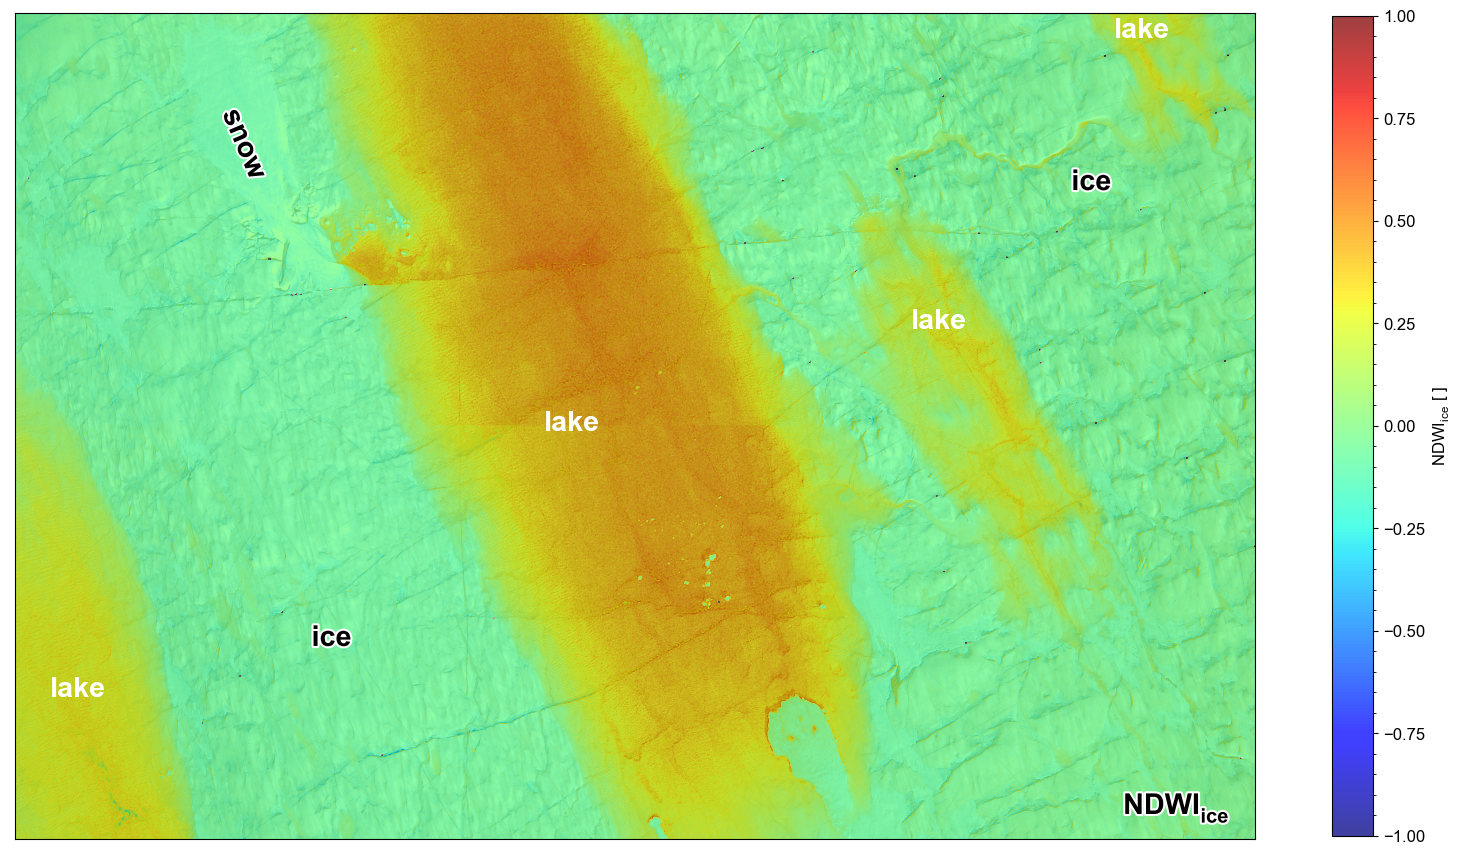

In [4]:
# plot transparent NDWI_ice over adjusted natural-color image

fig2, (ax2) = plt.subplots(1, 1, subplot_kw = {'xticks': [], 'yticks': []}) 
handle_ax2  = ax2.imshow(rgb_adj)
handle_ndwi = ax2.imshow(ndwi, interpolation='bilinear',cmap = plt.cm.jet,alpha = 0.75)
handle2_txt = ax2.text(1250,2500, "ice", fontsize = 'xx-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
handle3_txt = ax2.text(4250,700,  "ice", fontsize = 'xx-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
handle4_txt = ax2.text(2200,1650, "lake",fontsize = 'xx-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle5_txt = ax2.text(250,2700,  "lake",fontsize = 'xx-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle6_txt = ax2.text(3650,1250, "lake",fontsize = 'xx-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle7_txt = ax2.text(4450,100,  "lake",fontsize = 'xx-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle8_txt = ax2.text(900,650,   "snow",fontsize = 'xx-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k', rotation=-67)

handle2_txt.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])
handle3_txt.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])
handle8_txt.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])
handle6_txt = ax2.text(img_size[0]-100,img_size[1]-100, r'$\regularNDWI_{ice}$', fontsize = 'xx-large',font = 'Arial',fontweight = 'bold', ha = 'right', color = 'k')
handle6_txt.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])

cbar = fig2.colorbar(handle_ndwi, ax=ax2,location='right',label=r'$\regularNDWI_{ice}$ [ ]', shrink = 0.71) 
cbar.minorticks_on()

## Step 2: Surface classification distinguishing snow & ice from water using Otsu multi-thresholding
A common approach for classifying regions in gray-scale images is [Otsu's method](https://ieeexplore.ieee.org/document/4310076) that applys automatic image thresholding. The code uses the Python™ module [scikit-image](https://scikit-image.org/) which has implemented a modification of [Otsu's](https://ieeexplore.ieee.org/document/4310076) method that can determine multiple thresholds ([Liao, P-S., Chen, T-S. and Chung, P-C., “A fast algorithm for multilevel thresholding”, Journal of Information Science and Engineering 17 (5): 713-727, 2001.](https://doi.org/10.6688/JISE.2001.17.5.1)).

Image segmentation is done by applying multi-thresholding to the NDWI<sub>ice</sub> array.

In [5]:
# apply a surface classification method that distinguishes between ice/snow and water using
# NDWI_ice and Otsu's (1979) method for image classification.

import skimage as ski

# calculate multiple Otsu thresholds from NDWI_ice separating snow, ice, and water:
otsu_threshold = ski.filters.threshold_multiotsu(ndwi,classes=3, nbins=256)
for i in range(len(otsu_threshold)):
    print(f"Threshold {i+1:d}: {otsu_threshold[i]:5.2f}")

ValueError: autodetected range of [nan, nan] is not finite

Plot NDWI<sub>ice</sub> histogram with Otsu threshold separating snow & ice from water:

In [ ]:
# plot histogram distribution and the Otsu threshold value separating snow & ice from water
plt.rcParams['figure.figsize'] = [10, 5]
fig3, (ax3) = plt.subplots(1, 1) 
ax3.hist(ndwi.ravel(), bins=50,color = [0/256, 197/256, 255/256], edgecolor = [0/256, 77/256, 168/256])
#handle = ax3.axvline(otsu_threshold, color='r', linestyle='--', linewidth=1.5, label='Otsu threshold')
for k in range(len(otsu_threshold)):
    handle = ax3.axvline(otsu_threshold[k], color = [255/256, 5/256, 0/256], linestyle='--', linewidth=1.5, label='Otsu threshold')
ax3.set_xlabel(r'$\regularNDWI_{ice}$ [ ]')
ax3.set_ylabel('Probability density [ ]')
ax3.text(0.225,500000,"ice" ,   fontsize = 'large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
ax3.text(0.360,600000,"snow"  , fontsize = 'large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
ax3.text(-0.055,3350000,"water",fontsize = 'large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
ax3.minorticks_on()
ax3.set(ylim = (0, 3600000))
h0 = ax3.legend(handles = [handle], loc='upper right', labelspacing = 0.25)


Use the Otsu (1979) threshold to create a binary 2-D surface classification mask with 0 (False) for snow & ice and 1 (True) for water. 

In [ ]:
# create a binary 2-D surface classification mask with the first threshold found by Otsu's method representing the ice/water threshold
binary_lake_mask = ndwi >= otsu_threshold[0]

Plot transparent surface classification (snow & ice vs. water) based on Otsu (1979) threshold for NDWI<sub>ice</sub> over natural-color image.

In [ ]:
cmap_srf = (mpl.colors.ListedColormap(['yellow', 'blue']))
bounds = [0, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap_srf.N)
plt.rcParams['figure.figsize'] = [20, 15]
fig4, (ax4) = plt.subplots(1, 1, subplot_kw = {'xticks': [], 'yticks': []}) 
handle_ax4  = ax4.imshow(rgb_image)
handle_reg  = ax4.imshow(binary_lake_mask, interpolation='bilinear',cmap = cmap_srf,alpha = 0.35)

handle_txt = ax4.text(1250,2500, "ice",  fontsize = 'xx-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
handle_txt = ax4.text(4250,750,  "ice",  fontsize = 'xx-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
handle_txt = ax4.text(2250,1500, "water",fontsize = 'xx-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle_txt = ax4.text(900,650,   "snow", fontsize = 'xx-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k', rotation=-67)

handle6_txt = ax4.text(img_size[0]-100,img_size[1]-100, r'lake mask from $\regularNDWI_{ice}$ threshold', fontsize = 'xx-large',font = 'Arial',fontweight = 'bold', ha = 'right', color = 'k')
handle6_txt.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])

cbar4 = fig4.colorbar(handle_reg, ax=ax4,location='right', shrink = 0.71) 
cbar4.set_ticks([0.25,0.75])
cbar4.set_ticks(ticks=[0.25,0.75], labels=['snow & ice','water'],fontsize = 'x-large')

## Step 3: Connected Component Analysis (CCA) 
Determine coherent regions using Connected Component Analysis (CCA) based on Otsu multi-thresholding of NDWI<sub>ice</sub> . 

In [ ]:
from skimage.morphology import closing, square
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb
import matplotlib.patches as mpatches
import cv2 as cv

img = cv.imread(f_name_rgb)
assert img is not None, "file could not be read, check with os.path.exists()"

image = cv.cvtColor(img, cv.COLOR_BGR2RGB)
ndwi = calc_ndwi(img) #np.min(ndwi)
indx = image.shape

bw = closing(ndwi <= -0.11830188679245246, square(3)) # array of bool
# remove artifacts connected to image border
cleared = clear_border(bw)
# label image regions
label_image = label(bw)
image_label_overlay = label2rgb(label_image, image=image, bg_label=0, alpha=0.35, bg_color = None, colors = ['blue','red','green','yellow'])

# find the n largest values in array
# populate numpy array with region.area
roi_area = np.empty(0,dtype=float)
moments_central = np.empty(0,dtype=float)

for region in regionprops(label_image): # has 1160 elements... 
    roi_area = np.append(roi_area,region.area)
    moments_central = np.append(moments_central,region.moments_central)

n_highest = 4 # Note: automate selecting number of features using hostogram analysis of area sizes
temp = np.argpartition(-roi_area, n_highest)
result_args = temp[:n_highest] # indices of highest values
temp = np.partition(-roi_area, n_highest)
result = -temp[:n_highest]     # highest values

plot results

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)
#ax.imshow(image, alpha = 0.65)
#ax.set(xlim = (0, bw.shape[1]))
#ax.set(ylim = (0, bw.shape[0]))

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= min(result):
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle(
            (minc, minr),
            maxc - minc,
            maxr - minr,
            fill=False,
            edgecolor=[255/256, 255/256,   0/256],
            linestyle = '--',
            linewidth=2,
        )
        center = region.centroid
        h99 = ax.plot(center[1],center[0],'o', markersize = 9,color = 'white', lw = 2, label='centroid',markerfacecolor = [255/256, 255/256,   0/256])    
        plt.plot(center[1],center[0],'o', markersize = 3,color = None, label='centroid',markerfacecolor = 'black')    
        #ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
#plt.show()
plt.tight_layout()

import math
from matplotlib.patches import Ellipse

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= min(result):
        y0, x0 = region.centroid
        orientation = region.orientation
        orientation_deg = np.rad2deg(orientation)
        x1 = x0 + math.cos(orientation) * 0.5 * region.axis_minor_length
        y1 = y0 - math.sin(orientation) * 0.5 * region.axis_minor_length
        x2 = x0 - math.sin(orientation) * 0.5 * region.axis_major_length
        y2 = y0 - math.cos(orientation) * 0.5 * region.axis_major_length
        
        # plt.plot((x0, x1), (y0, y1), '-r', linewidth=2.5,clip_on = True)
        # plt.plot((x0, x2), (y0, y2), '-r', linewidth=2.5,clip_on = True)
        # plt.plot(x0, y0, '.g', markersize=15,clip_on = True)
        
        # https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Ellipse.html
        #plt.Ellipse([y1,x1],region.axis_minor_length,region.axis_major_length) 
        #ax.add_artist(Ellipse([x0,y0],region.axis_minor_length,region.axis_major_length,angle=-orientation_deg,alpha = 0.5,))
        p = ax.add_artist(Ellipse([x0,y0],region.axis_minor_length,region.axis_major_length,angle=-orientation_deg,alpha = 0.5, color=None,fill=None,ec='yellow', lw=2,clip_on = True,linestyle = "-."))
        p.set(clip_on = True)

import matplotlib as mpl
mpl.rcParams["legend.markerscale"] = 1 # The relative size of legend markers compared with the originally drawn ones. default = 1.0
mpl.rcParams["legend.frameon"] = True
mpl.rcParams["legend.fancybox"] = False
mpl.rcParams["legend.borderpad"] = 0.2 # default is 0.4
mpl.rcParams["legend.handlelength"] = 1.0 # defualt is 2.0
mpl.rcParams["legend.handletextpad"] = 0.4 # default is 0.8 (no effect it seems)
mpl.rcParams["legend.framealpha"] = 0.5  # default is 0.8
mpl.rcParams["legend.title_fontsize"] = 14

# ax[0,1].legend(title = 'Surface type')
#ax[0,1].legend(loc='lower right', labelspacing = 0.25, fontsize = 1.0*font_size, ncol = 2,title = 'Surface type')
#plt.legend(loc='lower right')
        
handle2_ax1 = ax.text(indx[1]-x_off,indx[0]-y_off, "natural-color (RGB) image", fontsize = 12,font = 'Arial',fontweight = 'bold', ha = 'right', color = 'k')
handle2_ax1.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])

plt.show()


**References**
* Kirillov, A. et al., Segment Anything, arXiv, http://arxiv.org/abs/2304.02643, 2023.
* Liao, P-S., Chen, T-S. and Chung, P-C., A fast algorithm for multilevel thresholding, Journal of Information Science and Engineering 17 (5): 713-727, https://doi.org/10.6688/JISE.2001.17.5.1, 2001.
* Otsu, N.: A Threshold Selection Method from Gray-Level Histograms, IEEE Trans. Syst., Man, Cybern., 9, 62–66, https://doi.org/10.1109/TSMC.1979.4310076, 1979.
* Studinger, M., Manizade, S. S., Linkswiler, M. A., and Yungel, J. K.: High-resolution imaging of supraglacial hydrological features on the Greenland Ice Sheet with NASA’s Airborne Topographic Mapper (ATM) instrument suite, The Cryosphere, 16, 3649–3668, https://doi.org/10.5194/tc-16-3649-2022, 2022.
* Yang, K. and Smith, L. C.: Internally drained catchments dominate supraglacial hydrology of the southwest Greenland Ice Sheet: Greenland Internally Drained Catchment, J. Geophys. Res. Earth Surf., 121, 1891–1910, https://doi.org/10.1002/2016JF003927, 2016.